# Transfer Learning Using Mixture Density Network Policies, And Sums Of Random Variables

## 1. Introduction

One of the disadvantages of current AI methods is their limited ability to exploit previously learned knowledge in order to speed up learning on new tasks. Off-policy RL methods such as DDPG *do* utilize experience in the form of a replay buffer, and transfer learning techniques exist to transfer learned knowledge from one domain to another; however, such methods typically have limited scope. 

In this notebook, I'll go over how a mixture density network can be trained using standard policy search methods, by recognizing what it is that standard RL methods are actually doing. I'll demonstrate this on a simple Pendulum control task, and then we'll analyze learned mixture to see if 


## 2. Background

### 2.1 Policy Search
We assume a Markov Decision Process, in which a trajectory is denoted by an ordered sequence of tuples $\{(s_{t}, a_{t}, r_{t}, T), (s_{t+1}, a_{t+1}, r_{t+1}, T),...\}$, with $s_{t}$ denoting states $s \in \mathcal{S}$ at time $t$, $a_{t}$ denoting actions $a \in \mathcal{A}$ at time $t$, $r_{t}$ denoting the reward from the environment, and $T$ denoting the transition function. Per the Markov assumption, we assume that past and future are conditionally independent of one another given the present.

In the task of policy search, our goal is to find a policy $\pi_{\theta} : \mathcal{S} \rightarrow \mathcal{A}$ that maximizes the discounted sum of returns from the environment:

\begin{equation}
G_{t} = \sum_{t=0}^{T}\gamma^{t}r_{t}
\end{equation}

In the typical formulation, $\pi_{\theta}$ is a stochastic function $\pi_{\theta}(a_{t}|s_{t})$ parameterized by a set of weights $\mathbf{\Theta}$, and our goal is to find the parameters that maximize the *expected* return under the policy using gradient-based optimization. To do so, we generally use one of the following functions:

\begin{equation}
V^{\pi}(s_{0}) = \mathbf{E}_{\pi}\left[\sum_{t=0}^{T}\gamma^{t}r_{t}|s_{0}=s\right]
\end{equation}

\begin{equation}
Q^{\pi}(s_{0},a_{0}) = \mathbf{E}_{\pi}\left[\sum_{t=0}^{T}\gamma^{t}r_{t}|s_{0}=s, a_{0}=a\right]
\end{equation}

\begin{equation}
A^{\pi}(s_{0}, a_{0}) = Q^{\pi}(s_{0},a_{0})-V^{\pi}(s_{0})
\end{equation}

In order to apply gradient-based optimization, we need an expression for the gradient. Generally, there are two methods for calculating this: backpropagating through a differentiable function, or using a Monte Carlo score function estimator:

\begin{equation}
\nabla_{\theta}J(\theta) = \mathbf{E}_{\pi}\left[\sum_{t=0}^{T}\nabla_{\theta}\log{\pi_{\theta}(a_{t}|s_{t})} (\hat{Q}^{\pi}(s_{t},a_{t})-V_{\phi}^{\pi}(s_{t}))\right]
\end{equation}

In this notebook, we'll focus primarily on the second method, as it is model-free, and generally straightforward to get working. Typically, we use an actor-critic architecture, in which the actor -- parameterized by $\theta$ -- selects actions, and a critic -- parameterized by $\phi$ -- is used to learn a baseline state-value. Since the state value is defined to be the expectation of the state-action value function over all actions, this gives us an empirical estimate of the advantage function. Technically, this is a special case of the use of control variates to reduce the variance of a Monte Carlo estimator, but the more intuitive way to think about it is that actions that are better than average are scaled positively, and actions that are worse than average are scaled negatively.  


### 2.2 Mixture Density Networks

#### 2.2.1 Standard Mixture Density Models
Mixture density networks are a technique for learning multi-modal distributions, and can be thought of as a form of soft clustering. In general, for a set of data, we might notice that it has more than one mode; if we try fitting a unimodal distribution to it, we will get either mean-seeking or mode-seeking behavior, depending on what we optimize. To get around this, we can model such a dataset using a mixture of unimodal density functions:

\begin{equation}
p(y) = \sum_{i \in \mathcal{I}}\omega_{i}\mathcal{N}(\mu_{i}(x), \sigma_{i}(x))
\end{equation}

\begin{equation}
\sum_{i \in \mathcal{I}} \omega_{i} = 1
\end{equation}

Such models are typically optimized using the expectation-maximization algorithm:

To sample from a mixture density network, we 

#### 2.2.2 Hierarchical Mixture Density Models
A hierarchical mixture density model is similar to a standard mixture density model, except that it follows a tree-like structure, with the mixture weightings acting as gates. A diagram of a typical hierarchical mixture of experts is given below:

Training a hierarchical mixture of experts is similar to training a standard mixture of experts model, except that now we have to recursively move through the graph. The probability density of the model is:

\begin{equation}
p(y) = \sum_{i \in \mathcal{I}}\sum_{j \in \mathcal{J}}\omega_{ij}\mathcal{N}\left(\mu_{ij}(x), \sigma_{ij}(x)\right)
\end{equation}

The algorithm for sampling from a hierarchical mixture density model is the same as sampling from a standard mixture density model:

STUFF

### 2.3 Sum of Random Variables

A second option that presents itself is a convolution of distributions. For $n$ distributions, we can combine them into a single unimodal distribution using:

\begin{equation}
Y \sim \mathcal{N}\left(\lambda(x) \mu(x)^{T}, \sum_{i \in \mathcal{I}}\lambda_{i}(x)^{2}\sigma_{i}(x)^{2}\right)
\end{equation}

This formula outlines the probability distribution of the sum of two random variables. That is, if $X \sim \mathcal{N}(\mu_x, \sigma_x)$ and $Y \sim \mathcal{N}(\mu_y, \sigma_y)$, then $Z = X + Y$ is also normally distributed as $Z \sim \mathcal{N}(\mu_x + \mu_y, \sigma_x^{2} + \sigma_y^{2})$.

This presents a potentially useful idea, since in some systems -- such as quadrotors -- actions can be additively combined. If our actions are sampled from stochastic policies, then in principle at least, we can bias the policy search using previously trained policies to more rapidly learn a new task. This bias can potentially let us learn certain things faster, by putting the agent into a space that is "close" to the desired solution, with the potential downside being that a previous policy could also bias the agent *away* from the desired solution -- a possibility we will test as well.

Conceptually, this policy falls between the MDN agent and the standard unimodal policy. We construct a unimodal distribution using the analytical solution of the convolution, sample from it, and then train as normal. The difference is that we bias the search towards a region that we think the solution lies in using previously trained policies.


## 3. Proposal

Given what we know about how Monte Carlo policy gradients work, in principle, we can substitute in a mixture density network for the policy as long as we can sample from it and get an estimate of the log-likelihood. Then, using a Monte Carlo rollout of the policy, we can get an expectation of its return, and step the policy weights in the direction that maximizes the return.

Conceptually, this is similar to some options frameworks such as the call-and-return architecture, except that in this case, we don't have a termination condition for a given policy -- instead, we just treat the whole thing as a single probabilistic model that we sample from and train.

What are the potential advantages of such an approach?


1. We might be able to autonomously learn higher-order or important features when doing multi-task learning. Similar to Convolutional Neural Networks that learn a cascading series of features, we might find that sub-policies differentiate from one another in a meaningful way;

2. If we use a hierarchical model, we can potentially use previously learned policies to bias the search of a current policy in order to speed up learning. Furthermore, we can avoid catastrophic forgetting by simply not propagating a gradient back into previously learned policies; and,

3. By combining graph-based models with deep neural networks and policy search, we might be able to leverage the strengths of both, such as causal reasoning for graphical models, and strong function approximation for deep learning.


## 4. Using Mixture Density Networks for Policy Search

In this section, we detail how to use mixture density networks for basic policy search. From Eqn. X, we can see that policy search algorithms parameterize a distribution as a function of parameters $\Theta$, and then sample from this distribution. Unlike supervised learning, in labels provide a measure of the cost of the parameters, in RL, we use the empirical return to scale the log-likelihood. That is, we sample from the distribution to select an action, take the action, receive a reward, and then observe the new state. Since we don't have access to a given set of labels, we use the return function to give us an estimate of the direction and magnitudes of the gradient.

We can utilize the same process substituting Eqn Y for the log-probability of a stochastic policy, and sampling from a mixture density network parameterized by $\Theta$. When we do this, the algorithm becomes:

STUFF


## 5. Experiments

In the following chunks of code, we conduct the following experiments:

1. We implement a basic Actor-Critic algorithm that is trained using a Monte Carlo policy gradient on a simple pendulum task in OpenAI Gym. This is mainly to test our basic implementation, and to provide a baseline against which we can measure.

2. We substitute the standard policy for a mixture density network with three sub-policies, and show that we can train the network to solve this basic task.

3. We apply the three models to a simple quadrotor flight task to determine if the mixture density networks are able to take advantage of previously learned policies. We do this by first training a policy to fly straight ahead, and then another to fly to the left. We then try to combine these two policies to complete the task of flying diagonally by additively composing the outputs of the two policies, and then finding a mixture that perfects what should already be a "good" policy.

4. We apply the policy to the task of collecting apples and avoiding bombs using a quadrotor. The aim of this task is to determine if the sub-policies learn distinct features -- for example, one policy learning to go after apples, and the other learning to avoid bombs.

### 5.1 Helper Functions
First off, we import all of the necessary modules, and define a bunch of helper functions. We define both a sequential training routine, and one that takes a vector of environments that it steps through simultaneously (this is necessary for tasks such as Pendulum).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from torch.distributions import Normal, Categorical
from common.multiprocessing_env import SubprocVecEnv

def plot(episodes, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title("frame %s. reward: %s" % (episodes[-1], rewards[-1]))
    plt.plot(episodes, rewards)
    plt.show()
    
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight, mean=0., std=0.1)
        torch.nn.init.constant_(m.bias, 0.1)

def test_env(agent, env):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.Tensor(state).unsqueeze(dim=0)
        action, value, log_prob = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.detach().numpy())
        state = next_state[:,0]
        total_reward += reward
    return total_reward

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

def rollout(agent, envs):
    r_, v_, lp_, dones = [], [], [], []
    t = 0
    ent = 0
    while t < batch_size:          
        action, value, log_prob = agent.select_action(state)
        next_state, reward, done, _ = envs.step(action.detach().numpy())
        next_state = torch.Tensor(next_state)
        r_.append(torch.Tensor(reward))
        v_.append(value)
        lp_.append(log_prob)
        dones.append(torch.Tensor(1-done))
        state = next_state
        t += 1
    trajectory = {
                "rewards": r_,
                "dones": dones,
                "values": v_,
                "log_probs": lp_}
    return trajectory

def train_env(agent, optimizer, envs, t_env, iterations=500, batch_size=256, epochs=1, log_interval=4):
    state = torch.Tensor(envs.reset())
    batch_mean = 0
    reward_list = []
    episode_list = []
    for ep in range(1, iterations+1):
        trajectory = rollout(agent, envs)
        for _ in range(epochs):
            agent.train(trajectory, optimizer)   
        if ep % log_interval == 0:
            test_rew = np.mean([test_env(agent, t_env) for _ in range(10)])
            episode_list.append(ep)
            reward_list.append(test_rew)
            plot(episode_list, reward_list)
    return episode_list, reward_list
            
            
def train_env_seq(agent, optimizer, env, iterations=300, batch_size=1024, epochs=1, log_interval=10):
    avg = 0
    int_avg = 0
    int_counter = 1
    reward_list = []
    episode_list = []
    for ep in range(1, iterations+1):
        s_, a_, r_, ns_, v_, lp_, dones = [], [], [], [], [], [], []
        t = 0
        eps = 0
        batch_mean = 0
        while t < batch_size:
            state = torch.Tensor(env.reset())
            running_reward = 0
            done = False
            while not done:          
                action, value, log_prob = agent.select_action(state.unsqueeze(dim=0))
                next_state, reward, done, _ = env.step(action.detach().numpy())
                running_reward += reward
                next_state = torch.Tensor(next_state[:-1]+next_state[-1])
                s_.append(state)
                a_.append(action)
                r_.append(torch.Tensor([reward]))
                ns_.append(next_state)
                v_.append(value)
                lp_.append(log_prob)
                dones.append(torch.Tensor([not done]))
                state = next_state
                t += 1
            eps += 1
            batch_mean = (batch_mean*(eps-1)+running_reward)/eps
        int_avg = (int_avg*(int_counter-1)+batch_mean)/int_counter
        int_counter += 1
        avg = (avg*(ep-1)+batch_mean)/ep
        trajectory = {
                    "states": s_,
                    "actions": a_,
                    "rewards": r_,
                    "next_states": ns_,
                    "dones": dones,
                    "values": v_,
                    "log_probs": lp_}
        for _ in range(epochs):
            agent.train(trajectory, optimizer)   
        if ep % log_interval == 0:
            reward_list.append(int_avg)
            episode_list.append(ep)
            plot(episode_list, reward_list)
            #print('Episode {}\t Interval average: {:.3f}\t Average reward: {:.3f}'.format(ep, int_avg, avg))
            int_avg = 0
            int_counter = 1
    return episode_list, reward_list

### 5.2 Standard Actor-Critic
Next, we'll write code for our agents using a basic REINFORCE update. The first is a standard stochastic policy parameterized by an MLP. Though we've denoted above that the standard deviation is a function of the input, the following implementation instead includes the log_std as a learned parameter that *isn't* a function of the input:

In [2]:
class Agent(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, std=0.):
        super(Agent, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.log_std = nn.Parameter(torch.ones(1, output_dim) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu = self.actor(x)
        std = self.log_std.exp().expand_as(mu)
        return mu, std, value
    
    def select_action(self, x):
        mu, sigma, value = self.forward(x)
        dist = Normal(mu, sigma)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, value, torch.sum(log_prob, dim=-1)
        
    def train(self, trajectory, optimizer, gamma=0.99):
        rewards = torch.stack(trajectory["rewards"])
        log_probs = torch.stack(trajectory["log_probs"])
        values = torch.stack(trajectory["values"]).squeeze(dim=-1)
        masks = torch.stack(trajectory["dones"])
        
        returns = torch.Tensor(rewards.size())
        prev_return = 0
        for i in reversed(range(rewards.size(0))):
            returns[i] = rewards[i]+gamma*prev_return*masks[i]
            prev_return = returns[i]
        deltas = returns-values
        
        optimizer.zero_grad()
        actor_loss = -torch.mean((log_probs*deltas.detach()))
        critic_loss = torch.mean(deltas.pow(2))
        loss = actor_loss + 0.5 * critic_loss
        loss.backward(retain_graph=True)
        optimizer.step()

### 5.3 MDN Actor-Critic
Next, we'll implement a basic MDN policy, and code a basic sub-policy that we'll call actor. As with the standard agent, I've opted no to make the log_std a function of the input: 

In [3]:
class Actor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, std=0.):
        super(Actor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim),)
        
        self.log_std = nn.Parameter(torch.ones(1, output_dim) * std)
        
        self.apply(init_weights)
        
    def forward(self, x):
        mu = self.actor(x)
        std = self.log_std.exp().expand_as(mu)
        return mu, std
    
class AgentMDN(torch.nn.Module):
    def __init__(self, *agents, hidden_dim=128):
        super(AgentMDN, self).__init__()
        self.agents = torch.nn.ModuleList([a for a in agents])
        self.num_policies = len(self.agents)
        self.num_actions = self.agents[0].output_dim        
        self.input_dim = int(self.agents[0].input_dim)
        
        self.mixing = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, self.num_policies),)
        
        self.value = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 1),)
        
        self.apply(init_weights)
        
    def forward(self, x):
        mixing = F.softmax(self.mixing(x), dim=-1)
        value = self.value(x)
        return mixing, value
    
    def select_action(self, x, test=False):
        scores, value = self.forward(x)
        cat_dist = Categorical(scores)
        pol_idx = cat_dist.sample().int()
        actions = []
        for i in range(pol_idx.size(0)):
            mu, sigma = self.agents[pol_idx[i]](x[i].unsqueeze(0))
            norm_dist = Normal(mu, sigma)
            action = norm_dist.sample()
            actions.append(action.squeeze(0))
        actions = torch.stack(actions)
        p = torch.zeros(num_envs, self.num_actions)
        for i, a in enumerate(self.agents):
            mu, sigma = a(x)
            dist = Normal(mu, sigma)
            lp = dist.log_prob(actions)
            p += scores[:, i].unsqueeze(1)*torch.exp(lp)
        log_probs = torch.sum(torch.log(p), dim=-1)
        return actions, value, log_probs
    
    def train(self, trajectory, optimizer, gamma=0.99):
        rewards = torch.stack(trajectory["rewards"])
        log_probs = torch.stack(trajectory["log_probs"])
        values = torch.stack(trajectory["values"]).squeeze(dim=-1)
        masks = torch.stack(trajectory["dones"])
        
        returns = torch.Tensor(rewards.size())
        prev_return = 0
        for i in reversed(range(rewards.size(0))):
            returns[i] = rewards[i]+gamma*prev_return*masks[i]
            prev_return = returns[i]
        deltas = returns-values
        
        optimizer.zero_grad()
        actor_loss = -(log_probs*deltas.detach()).mean()
        critic_loss = torch.mean(deltas.pow(2))
        loss = actor_loss + 0.5 * critic_loss
        loss.backward(retain_graph=True)
        optimizer.step()
        

class AgentMDNTwo(AgentMDN):
    def __init__(self, *agents, hidden_dim=128):
        super(AgentMDNTwo, self).__init__(*agents, hidden_dim=128)
    
    def select_action(self, x, test=False):
        scores, value = self.forward(x)
        cat_dist = Categorical(scores)
        pol_idx = cat_dist.sample().int()
        actions = []
        for i in range(pol_idx.size(0)):
            mu, sigma, _ = self.agents[pol_idx[i]](x[i].unsqueeze(0))
            norm_dist = Normal(mu, sigma)
            action = norm_dist.sample()
            actions.append(action.squeeze(0))
        actions = torch.stack(actions)
        p = torch.zeros(1, self.num_actions)
        for i, a in enumerate(self.agents):
            mu, sigma, _ = a(x)
            dist = Normal(mu, sigma)
            lp = dist.log_prob(actions)
            p += scores[:, i].unsqueeze(1)*torch.exp(lp)
        log_probs = torch.sum(torch.log(p), dim=-1)
        return actions, value, log_probs 

### 5.4 Convolution of Distributions Actor-Critic
Finally, we'll implement a basic convolution of distributions policy by inheriting from our MDN policy, and overriding the select_action method:

In [4]:
class AgentConv(AgentMDN):
    def __init__(self, *agents, hidden_dim=128):
        super(AgentConv, self).__init__(*agents, hidden_dim=128)
    
    def select_action(self, x, test=False):
        scores, value = self.forward(x)
        mus, sigmas = [], []
        for a in self.agents:
            mu, sigma = a(x)
            mus.append(mu)
            sigmas.append(sigma)
        mus = torch.cat(mus, dim=1)
        sigmas = torch.cat(sigmas, dim=1)
        scores = scores.expand_as(mus)
        mu = (scores*mus).sum(dim=1, keepdim=True)
        sigma = ((scores*sigmas).pow(2)).sum(dim=1, keepdim=True).pow(0.5)
        dist = Normal(mu, sigma)
        action = dist.sample()
        lp = torch.sum(dist.log_prob(action), dim=-1)
        return action, value, lp

class AgentConvTwo(AgentMDN):
    def __init__(self, *agents, hidden_dim=128):
        super(AgentConvTwo, self).__init__(*agents, hidden_dim=128)
    
    def select_action(self, x, test=False):
        scores, value = self.forward(x)
        mus, sigmas = [], []
        for a in self.agents:
            mu, sigma, _ = a(x.unsqueeze(0))
            mus.append(mu)
            sigmas.append(sigma)
        mus = torch.cat(mus, dim=1)
        sigmas = torch.cat(sigmas, dim=1)
        
        print(mus.size())
        print(scores.size())
        
        scores = scores.unsqueeze(dim=-1).expand_as(mus)
        mu = (scores*mus).sum(dim=1, keepdim=True)
        sigma = ((scores*sigmas).pow(2)).sum(dim=1, keepdim=True).pow(0.5)
        dist = Normal(mu, sigma)
        action = dist.sample()
        lp = torch.sum(dist.log_prob(action), dim=-1)
        return action, value, lp    

## 6. Results

### 6.1 Experiment 1 -- Validating the Baseline

To begin with, we'll test the training loop for the standard policy gradient method. Our policy is a standard MLP that parameterizes independent means and log-standard deviations. Since Pendulum has no termination condition, we either need to terminate the policy after a fixed number of timesteps, or initialize multiple policies. We do the latter here, creating 32 environments, and sampling from the same policy for each one.

In [5]:
num_envs = 16
env_name = "Pendulum-v0"
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
t_env = gym.make(env_name)

state_dim = t_env.observation_space.shape[0]
action_dim = t_env.action_space.shape[0]

[2019-05-15 14:45:38,223] Making new env: Pendulum-v0
[2019-05-15 14:45:38,228] Making new env: Pendulum-v0
[2019-05-15 14:45:38,239] Making new env: Pendulum-v0
[2019-05-15 14:45:38,240] Making new env: Pendulum-v0
[2019-05-15 14:45:38,262] Making new env: Pendulum-v0
[2019-05-15 14:45:38,253] Making new env: Pendulum-v0
[2019-05-15 14:45:38,286] Making new env: Pendulum-v0
[2019-05-15 14:45:38,344] Making new env: Pendulum-v0
[2019-05-15 14:45:38,347] Making new env: Pendulum-v0
[2019-05-15 14:45:38,314] Making new env: Pendulum-v0
[2019-05-15 14:45:38,395] Making new env: Pendulum-v0
[2019-05-15 14:45:38,434] Making new env: Pendulum-v0
[2019-05-15 14:45:38,470] Making new env: Pendulum-v0
[2019-05-15 14:45:38,474] Making new env: Pendulum-v0
[2019-05-15 14:45:38,485] Making new env: Pendulum-v0
[2019-05-15 14:45:38,526] Making new env: Pendulum-v0
[2019-05-15 14:45:38,560] Making new env: Pendulum-v0


And now for the training:

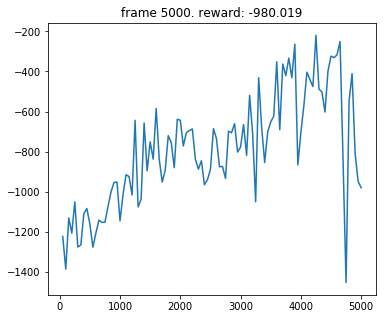

In [8]:
standard_agent = Agent(state_dim, 256, action_dim)
standard_agent_optimizer = torch.optim.Adam(standard_agent.parameters())
standard_agent_eps, standard_agent_rews = train_env(standard_agent, standard_agent_optimizer, envs, t_env, iterations=5000, batch_size=20, log_interval=50)

As we can see, the agent has learned the task in roughly 1 million timesteps, and converges to a reward of around -280. This gives us an idea that the basic implementation seems to be working. In the next experiment, we'll test our MDN agent and Convolution agent to see if they can learn even on this basic task.

### 6.2 Experiment 2 -- Validating the Implementations

First, we'll initialize our MDN agent and train it:

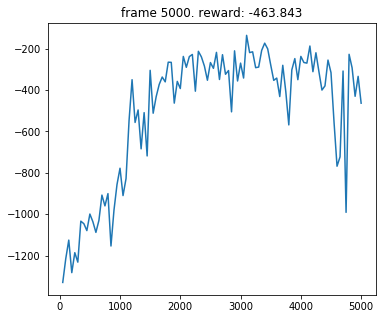

In [25]:
p1_mdn = Actor(state_dim, 64, action_dim)
p2_mdn = Actor(state_dim, 64, action_dim)
p3_mdn = Actor(state_dim, 64, action_dim)
mdn_agent = AgentMDN(p1_mdn, p2_mdn, p3_mdn, hidden_dim=256)
mdn_agent_optimizer = torch.optim.Adam(mdn_agent.parameters())
mdn_agent_eps, mdn_agent_rews = train_env(mdn_agent, mdn_agent_optimizer, envs, t_env, iterations=5000, batch_size=20, log_interval=50)

As we can see, the agent learns to reach a similar performance in around 1 million timesteps, and converges to a slightly better performance than the standard agent. Interestingly, it seems far more robust to collapse than the standard policy search method.

Next, we'll train the convolution agent:

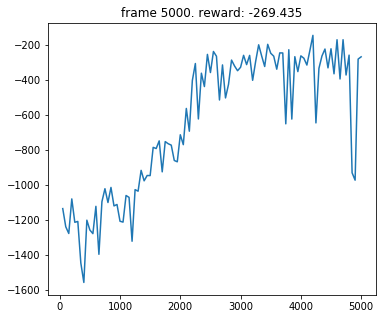

In [27]:
p1_conv = Actor(state_dim, 64, action_dim)
p2_conv = Actor(state_dim, 64, action_dim)
p3_conv = Actor(state_dim, 64, action_dim)
conv_agent = AgentConv(p1_conv, p2_conv, p3_conv, hidden_dim=256)
conv_optimizer = torch.optim.Adam(conv_agent.parameters())
conv_agent_eps, conv_agent_rews = train_env(conv_agent, conv_optimizer, envs, t_env, iterations=5000, batch_size=20, log_interval=50)

Graphing the results below:

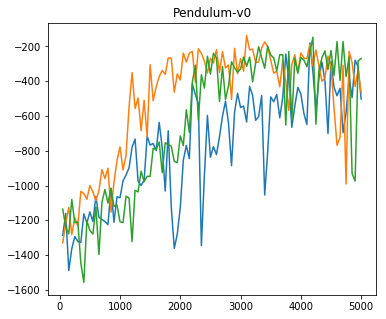

In [28]:
clear_output(True)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("Pendulum-v0")
plt.plot(standard_agent_eps, standard_agent_rews)
plt.plot(mdn_agent_eps, mdn_agent_rews)
plt.plot(conv_agent_eps, conv_agent_rews)
plt.show()

### 6.3 Experiment 3 -- Knowledge Transfer

Next, we'll create a simple flight control task to determine if our MDN agent is able to effectively utilize previously existing policies. To do this, we have defined two tasks -- Task 1 and Task 2 -- in which the agent is trained to fly to a point 2m forward of it, and 2m left of it, respectively. We will first train two policies using TRPO-PEB to execute these two tasks: 

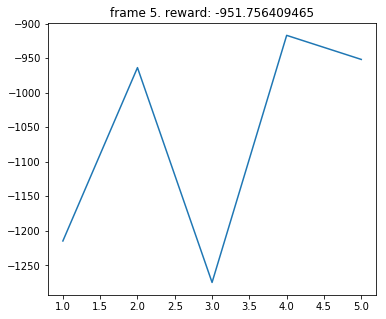

/Users/seanmorrison/anaconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [5]:
import gym_aero
import algs.ind.trpo_peb as trpo_peb
import config as cfg

env_one = gym.make("One-v0")
params = cfg.trpo

state_dim = env_one.observation_space.shape[0]
action_dim = env_one.action_space.shape[0]
hidden_dim = 256

def train_agent(env):
    pi = Actor(state_dim, hidden_dim, action_dim)
    beta = Actor(state_dim, hidden_dim, action_dim)
    critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, 1))
    agent = trpo_peb.TRPO(pi, beta, critic, params["network_settings"], GPU=False)
    crit_opt = torch.optim.Adam(critic.parameters())
    ep, rew = train_env_seq(agent, crit_opt, env_one, batch_size=128, iterations=5, epochs=1, log_interval=1)
    return ep, rew, agent

ep, rew, agent_one = train_agent(env_one)
torch.save(agent_one, "one.pth.tar")

Next, we'll train an agent to fly in a sideways direction:

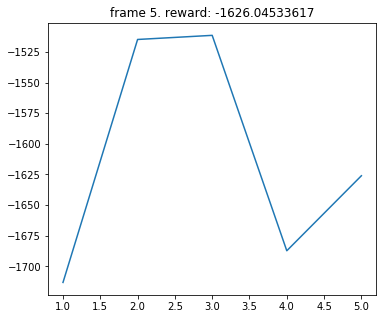

/Users/seanmorrison/anaconda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [6]:
import gym_aero
import algs.ind.trpo_peb as trpo_peb
import config as cfg

env_two = gym.make("Two-v0")
params = cfg.trpo

state_dim = env_two.observation_space.shape[0]
action_dim = env_two.action_space.shape[0]
hidden_dim = 256

ep, rew, agent_two = train_agent(env_two)
torch.save(agent_two, "two.pth.tar")

Now we'll train the MDN agent. We can modify our agent to include it's own (untrained) policy as well, which should let it use only the new policy if the others prove to be detrimental. This is done in the following code:

In [7]:
three = gym.make("Three-v0")
p1_diag = torch.load("./one.pth.tar")
p2_diag = torch.load("./two.pth.tar")
p3_diag = Agent(state_dim, 64, action_dim)
diag_agent = AgentMDNTwo(p1_diag, p2_diag, p3_diag, hidden_dim=256)
diag_agent_optimizer = torch.optim.Adam(diag_agent.parameters())
diag_agent_eps, diag_agent_rews = train_env_seq(diag_agent, diag_agent_optimizer, three)

[2019-05-15 15:37:46,090] Making new env: Three-v0



Quadrotor environment initialized with parameters:
--------------------------------------------------
Aircraft Mass: 			0.65 kg
Propeller Radius: 		0.06 m
Number of Motors: 		4
Hover Percentage: 		0.5
Moment Arm Length: 		0.23 m
Thrust Coefficient: 		0.00003
Torque Coefficient: 		0.00000
Drag Coefficient: 		0.00900
Motor Decay Coefficient: 	5.55556
Aero Moment Coefficient: 	0.00090
Gravity: 			9.81ms^-2
Maximum RPM: 			319.15674 rad/s
Hover RPM: 			225.67789 rad/s
Maximum Thrust: 		3.18825 N/motor
Hover Thrust: 			1.59413 N/motor
Inertia Tensor:
[[ 0.0075  0.      0.    ]
 [ 0.      0.0075  0.    ]
 [ 0.      0.      0.013 ]]
--------------------------------------------------



NotImplementedError: 

Next, we'll see how the convolution agent does:

In [23]:
p1_c2 = torch.load("./one.pth.tar")
p2_c2 = torch.load("./two.pth.tar")
p3_c2 = Agent(state_dim, 64, action_dim)
c2_agent = AgentConvTwo(p1_c2, p2_c2, p3_c2, hidden_dim=256)
c2_agent_optimizer = torch.optim.Adam(c2_agent.parameters())
c2_agent_eps, c2_agent_rews = train_env_seq(c2_agent, c2_agent_optimizer, three)

torch.Size([1, 3, 4])
torch.Size([1, 3])


RuntimeError: The expanded size of the tensor (4) must match the existing size (3) at non-singleton dimension 2

And comparing to a standard agent:

In [ ]:
agent = Agent(state_dim, 256, action_dim)
optimizer = torch.optim.Adam(agent.parameters())
conv_agent_eps, conv_agent_rews = train_env_seq(agent, optimizer, three)

And an agent with all untrained policies:

In [ ]:
p1, p2, p3 = Actor(state_dim, 64, action_dim), Actor(state_dim, 64, action_dim), Actor(state_dim, 64, action_dim)
agent = Agent(p1, p2, p3, hidden_dim=256)
optimizer = torch.optim.Adam(agent.parameters())
conv_agent_eps, conv_agent_rews = train_env(agent, optimizer, three)

Graphing the results below:

In [ ]:
clear_output(True)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title("Knowledge Transfer Task")
plt.plot(standard_agent_eps, standard_agent_rews)
plt.plot(mdn_agent_eps, mdn_agent_rews)
plt.plot(conv_agent_eps, conv_agent_rews)
plt.show()

We can visualize a clustering in the observation space to see where the different policies take priority. To do this, we create an n-dimensional range, and then use dimensionality reduction to view the most important axes. 

### 6.4 Experiment 4 -- Learned Features on Hierarchical Tasks

Finally, we put our policy to the task of learning how to collect apples and avoid bombs in an enclosed environment to determine if each policy can learn distinct features. We do this below:

## 6. Discussion
Our implementation of the MDN policy is very similar to a call-and-return options framework, in which a categorical meta-policy selects between a pre-defined set of sub-policies. In fact, we can show that the policy gradient over options is the same as the expression for the log-probability of a mixture density network, scaled by the return function. Proof:

Unlike existing continuous-action options frameworks such as the option-critic, we use a standard Monte-Carlo policy gradient update instead of an online actor-critic update. As a result, our intra-option value function function $Q(s,\omega, a)$ is empirically estimated from the rollouts, rather than learned. Similarly, 

### 6.2 Limitations
One of the potential limitations of this method is that as the number of contributing policies increases, the chances of an individual policy being selected may decrease. This means that policies with low weighting values (or in cases with many policies with equal weighting values) the number of examples available to train an individual policies decreases. A potential solution to this problem was outlined in [].

Further more, we make no assumptions or proposals regarding how 

## 7. Related Work

We can think of the MDN policy as a special case of the options framework, 

## 8. Conclusion

Stuff goes here

## 9. References

Stuff goes here